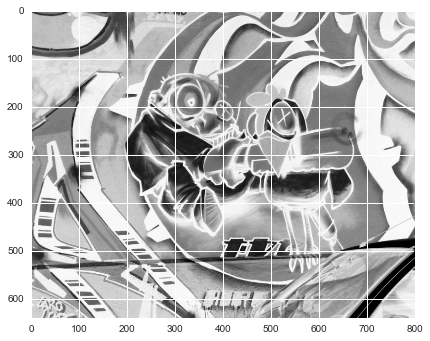

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
from  scipy.ndimage import zoom as imzoom
import sys
import os

import seaborn as sns

from PIL import Image
from matplotlib import mlab
import matplotlib.pyplot as plt
import numpy as np
from pytorch_sift import SIFTNet
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.optim as optim
from tqdm import tqdm
import math
import torch.nn.functional as F
USE_CUDA = False

LOG_DIR = 'log_snaps'
BASE_LR = 0.00000001
from SpatialTransformer2D import SpatialTransformer2d
from HardNet import HardNet
hardnet = HardNet()
checkpoint = torch.load('HardNetLib.pth')
hardnet.load_state_dict(checkpoint['state_dict'])

img = Image.open('/home/old-ufo/Dropbox/Mik/graf/img1.png').convert('RGB')
img = np.sum(np.array(img)/255.0, axis = 2)
plt.imshow(img)
var_image = torch.autograd.Variable(torch.from_numpy(img.astype(np.float32)))
var_image_reshape = var_image.view(1, 1, var_image.size(0),var_image.size(1))
#var_image_reshape = var_image_reshape.transpose(2,3).transpose(1,2)
var_image_reshape.shape

class SparseImgRepresenter(nn.Module):
    def __init__(self, 
             detector_net = None,
             descriptor_net = None,    
             use_cuda = False):
        super(SparseImgRepresenter, self).__init__()
        self.detector = detector_net;
        self.descriptor = descriptor_net;
        return
    def forward(self, input_img, skip_desc = False):
        aff_norm_patches, LAFs = self.detector(input_img)
        if not skip_desc:
            descs = self.descriptor(aff_norm_patches);
            return aff_norm_patches, LAFs, descs
        return aff_norm_patches, LAFs
from copy import deepcopy
def LAF2pts(LAF, n_pts = 50):
    a = np.linspace(0, 2*np.pi, n_pts);
    x = list(np.cos(a))
    x.append(0)
    x = np.array(x).reshape(1,-1)
    y = list(np.sin(a))
    y.append(0)
    y = np.array(y).reshape(1,-1)
    
    HLAF = np.concatenate([LAF, np.array([0,0,1]).reshape(1,3)])
    H_pts =np.concatenate([x,y,np.ones(x.shape)])
    #print H_pts.shape, HLAF.shape
    H_pts_out = np.transpose(np.matmul(HLAF, H_pts))#np.tensordot(HLAF,H_pts, axes = 0)
    H_pts_out[:,0] = H_pts_out[:,0] / H_pts_out[:, 2]
    H_pts_out[:,1] = H_pts_out[:,1] / H_pts_out[:, 2]
    return H_pts_out[:,0:2]
def visualize_LAFs(img, LAFs):
    plt.figure()
    plt.imshow(255 - img)
    for i in range(len(LAFs)):
        LAF = deepcopy(LAFs[i,:,:])
        LAF[0,:] *= float(img.shape[1])
        LAF[1,:] *= float(img.shape[0])
        #print LAF
        ell = LAF2pts(LAF)
        plt.plot( ell[:,0], ell[:,1], 'r')
    plt.show()
    return


In [2]:
print var_image_reshape.shape

torch.Size([1, 1, 640, 800])


In [2]:
class HessianResp(nn.Module):
    def __init__(self):
        super(HessianResp, self).__init__()
        self.gx =  nn.Sequential(nn.Conv2d(1, 1, kernel_size=(1,3), padding = (0,1), bias = False))
        for l in self.gx:
            if isinstance(l, nn.Conv2d):
                l.weight.data = torch.from_numpy(np.array([[[[-0.5, 0, 0.5]]]], dtype=np.float32))
        self.gy =  nn.Sequential(nn.Conv2d(1, 1, kernel_size=(3,1), padding = (1,0), bias = False))
        for l in self.gy:
            if isinstance(l, nn.Conv2d):
                l.weight.data = torch.from_numpy(np.array([[[[-0.5], [0], [0.5]]]], dtype=np.float32))
        return
    def forward(self, x):
        gx = self.gx(x)
        gy = self.gy(x)
        gxx = self.gx(gx)
        gxy = self.gy(gx)
        gyy = self.gy(gy)
        return gxx * gyy - gxy * gxy
        

In [3]:
class NMS2d(nn.Module):
    #Outputs coordinatas 
    def __init__(self, kernel_size = 3, threshold = 0, use_cuda = False):
        super(NMS2d, self).__init__()
        self.MP = nn.MaxPool2d(kernel_size, stride=1, return_indices=False, padding = 1)
        self.eps = 1e-8
        self.th = threshold
        self.use_cuda = use_cuda
        return
    def forward(self, x):
        ttt = self.MP(x)
        if self.th > self.eps:
            return  (torch.abs(ttt) > self.th) * ((x + self.eps - ttt) > 0)
        else:
            return (x + self.eps - ttt)


In [25]:
class GaussianBlur(nn.Module):
    def __init__(self,sigma=1):
        super(GaussianBlur, self).__init__()
        weight = self.calculate_weights(sigma)
        self.register_buffer('buf', weight)
        return
    def calculate_weights(self,  sigma):
        kernelSize = int(2.0 * 3.0 * sigma + 1.0)
        if (kernelSize 
            % 2 == 0):
            kernelSize = kernelSize + 1;
        halfSize = float(kernelSize) / 2.;
        self.pad = int(np.floor(halfSize))
        sigma2 = sigma*sigma;
        kernel = np.zeros((kernelSize,kernelSize))
        for y in range(kernelSize):
            for x in range(kernelSize):
                disq = (y - halfSize)*(y - halfSize) +  (x - halfSize)*(x - halfSize);
                kernel[y,x] = np.exp(-disq / sigma2)
        kernel = kernel / kernel.sum();
        return torch.from_numpy(kernel.astype(np.float32)).view(1,1,kernelSize,kernelSize);
    def forward(self, x):
        return F.conv2d(x, Variable(self.buf), padding = int(self.pad ))

def getPoolingKernel(kernel_size = 25):
    step = 1. / float(np.floor( kernel_size / 2.));
    x_coef = np.arange(step/2., 1. ,step)
    xc2 = np.hstack([x_coef,[1], x_coef[::-1]])
    kernel = np.outer(xc2.T,xc2)
    kernel = np.maximum(0,kernel)
    return kernel
def get_bin_weight_kernel_size_and_stride(patch_size, num_spatial_bins):
    bin_weight_stride = int(round(2.0 * math.floor(patch_size / 2) / float(num_spatial_bins + 1)))
    bin_weight_kernel_size = int(2 * bin_weight_stride - 1);
    return bin_weight_kernel_size, bin_weight_stride


class AffineShapeEstimator(nn.Module):
    def __init__(self, use_cuda = False, 
                 threshold = 0.001, patch_size = 19):
        super(AffineShapeEstimator, self).__init__()
        self.threshold = threshold;
        self.use_cuda = use_cuda;
        self.PS = patch_size
        self.gx =  nn.Sequential(nn.Conv2d(1, 1, kernel_size=(1,3), padding = (0,1), bias = False))
        for l in self.gx:
            if isinstance(l, nn.Conv2d):
                l.weight.data = torch.from_numpy(np.array([[[[-1, 0, 1]]]], dtype=np.float32))
        self.gy =  nn.Sequential(nn.Conv2d(1, 1, kernel_size=(3,1), padding = (1,0), bias = False))
        for l in self.gy:
            if isinstance(l, nn.Conv2d):
                l.weight.data = torch.from_numpy(np.array([[[[-1], [0], [1]]]], dtype=np.float32))
        self.pk = nn.Sequential(nn.Conv2d(1, 1, kernel_size=self.PS,
                            stride = self.PS, padding = 0,
                            bias = False))
        for l in self.pk:
            if isinstance(l, nn.Conv2d):
                nw = getPoolingKernel(kernel_size = self.PS)
                new_weights = np.array(nw.reshape((1, 1, self.PS, self.PS)))
                l.weight.data = torch.from_numpy(new_weights.astype(np.float32))
        return
    def invSqrt(self,a,b,c):
        eps = 1e-10
        r1 = (b != 0).float() * (c - a) / (2. * b + eps) + 0.
        t1 = torch.sign(r1) / (torch.abs(r1) + torch.sqrt(1. + r1*r1));
        r = 1.0 / torch.sqrt( 1. + t1*t1)
        t = t1*r;
        
        r = r * (b != 0).float() + 1.0 * (b == 0).float();
        t = t * (b != 0).float() + 0. * (b == 0).float();
        
        x = 1. / torch.sqrt( r*r*a - 2*r*t*b + t*t*c + eps)
        z = 1. / torch.sqrt( t*t*a + 2*r*t*b + r*r*c + eps)
        
        d = torch.sqrt( x * z)
        
        x = x / d
        z = z / d
        
        l1 = torch.max(x,z)
        l2 = torch.min(x,z)
        
        new_a = r*r*x + t*t*z
        new_b = -r*t*x + t*r*z
        new_c = t*t*x + r*r *z

        return l1,l2, new_a, new_b, new_c
    def forward(self,x):
        gx = self.gx(x)
        gy = self.gy(x)
        a1 = self.pk(gx*gx).view(x.size(0),-1).mean(dim=1)
        b1 = self.pk(gx*gy).view(x.size(0),-1).mean(dim=1)
        c1 = self.pk(gy*gy).view(x.size(0),-1).mean(dim=1)
        l1,l2,a, b, c = self.invSqrt(a1,b1,c1)
        rat1 = l1/l2
        eig_ratio = 1. - 1./rat1;
        
        den = torch.sqrt(a*c - b*b)
        mask = (rat1 <= 6).float().view(-1);
        a = a * mask / den + 1. * (1.- mask)
        b = b * mask / den + 0. * (1.- mask)
        c = c * mask / den + 1. * (1.- mask)
        return a.view(-1,1,1),b.view(-1,1,1),c.view(-1,1,1), eig_ratio
    
class OrientationDetector(nn.Module):
    def __init__(self, use_cuda = False,
                mrSize = 3.0, patch_size = None):
        super(OrientationDetector, self).__init__()
        if patch_size is None:
            patch_size = 32;
        self.bin_weight_kernel_size, self.bin_weight_stride = get_bin_weight_kernel_size_and_stride(patch_size, 1)
        self.mrSize = mrSize;
        self.num_ang_bins = 72
        self.patch_size = patch_size;
        self.gx =  nn.Sequential(nn.Conv2d(1, 1, kernel_size=(1,3), padding = (0,1), bias = False))
        for l in self.gx:
            if isinstance(l, nn.Conv2d):
                l.weight.data = torch.from_numpy(np.array([[[[-1, 0, 1]]]], dtype=np.float32))
        self.gy =  nn.Sequential(nn.Conv2d(1, 1, kernel_size=(3,1), padding = (1,0), bias = False))
        for l in self.gy:
            if isinstance(l, nn.Conv2d):
                l.weight.data = torch.from_numpy(np.array([[[[-1], [0], [1]]]], dtype=np.float32))
        self.pk = nn.Sequential(nn.Conv2d(1, 1, kernel_size=(self.bin_weight_kernel_size),
                            stride = self.bin_weight_stride, padding = 0,
                            bias = False))
        for l in self.pk:
            if isinstance(l, nn.Conv2d):
                nw = np.ones((self.bin_weight_kernel_size,self.bin_weight_kernel_size))
                new_weights = np.array(nw.reshape((1, 1, self.bin_weight_kernel_size, self.bin_weight_kernel_size)))
                l.weight.data = torch.from_numpy(new_weights.astype(np.float32))
        self.angular_smooth =  nn.Sequential(nn.Conv1d(1, 1, kernel_size=3, padding = 1, bias = False))
        for l in self.angular_smooth:
            if isinstance(l, nn.Conv1d):
                print l.weight.shape
                l.weight.data = torch.from_numpy(np.array([[[0.34, 1, 0.34]]], dtype=np.float32))
        self.gk = torch.from_numpy(self.CircularGaussKernel(kernlen=patch_size).astype(np.float32))
        self.gk = Variable(self.gk, requires_grad=False)
        if use_cuda:
            self.gk = self.gk.cuda()
        return
    def CircularGaussKernel(self,kernlen=21):
        halfSize = kernlen / 2;
        r2 = float(halfSize*halfSize);
        sigma2 = 0.9 * r2;
        disq = 0;
        kernel = np.zeros((kernlen,kernlen))
        for y in range(kernlen):
            for x in range(kernlen):
                disq = (y - halfSize)*(y - halfSize) +  (x - halfSize)*(x - halfSize);
                if disq < r2:
                    kernel[y,x] = math.exp(-disq / sigma2)
                else:
                    kernel[y,x] = 0.
        return kernel

    def forward(self, x):
        gx = self.gx(x)
        gy = self.gy(x)
        mag = torch.sqrt(gx * gx + gy * gy + 1e-10)
        mag = mag * self.gk.unsqueeze(0).unsqueeze(0).expand_as(mag)
        ori = torch.atan2(gy,gx)
        #mag  = mag * self.gk.expand_as(mag)
        o_big =   float(self.num_ang_bins) *(ori + 2.0 * math.pi )/ (2.0 * math.pi)
        bo0_big =  torch.floor(o_big)
        wo1_big = o_big - bo0_big
        bo0_big =  bo0_big %  self.num_ang_bins
        bo1_big = (bo0_big + 1) % self.num_ang_bins
        wo0_big = (1.0 - wo1_big) * mag
        wo1_big = wo1_big * mag
        ang_bins = []
        for i in range(0, self.num_ang_bins):
            ang_bins.append(self.pk((bo0_big == i).float() * wo0_big + (bo1_big == i).float() * wo1_big))
        ang_bins = torch.cat(ang_bins,1).view(-1,1,self.num_ang_bins)
        #ang_bins = self.angular_smooth(ang_bins)
        #print ang_bins[0,:]
        #print ang_bins
        values, indices = ang_bins.view(-1,self.num_ang_bins).max(1)
        return 2. * math.pi * indices.float() / float(self.num_ang_bins)
class HessianAffinePatchExtractor(nn.Module):
    def __init__(self, use_cuda = False, 
                 border = 16,
                 num_features = 500,
                 patch_size = 32,
                 mrSize = 3.0,
                 nlevels = 8,
                 init_sigma = 1.6):
        super(HessianAffinePatchExtractor, self).__init__()
        self.mrSize = mrSize
        self.PS = patch_size
        self.b = border;
        self.num = num_features
        self.use_cuda = use_cuda
        self.nlevels = nlevels
        self.init_sigma = init_sigma
        self.Hes = HessianResp()
        self.NMS2d = NMS2d(threshold = 0, use_cuda = use_cuda)
        self.OriDet = OrientationDetector(patch_size = 19);
        self.AffShape = AffineShapeEstimator()
        return
    def zero_response_at_border(self,x):
        x[:,:,:self.b, :] =  -10000
        x[:,:, -self.b:-1, :] =  -10000
        x[:,:,:,:self.b] =  -10000
        x[:,:,:, -self.b:-1] =  -10000
        return x
    def generate_scale_pyramid(self, x):
        curSigma = 0.5;
        pixelDistance = 1.0;
        minSize = 2 * self.b + 2;
        if self.init_sigma > curSigma:
            sigma = np.sqrt(self.init_sigma**2 - curSigma**2)
            curr = GaussianBlur(sigma = sigma)(x)
        else:
            sigma = curSigma
            curr = x
        sigmas = [sigma]
        pyr = [curr]
        while (curr[0,0,:,:].size(0) > minSize) and (curr[0,0,:,:].size(1) > minSize):
            pixelDistance = pixelDistance * 2.0
            sigmas.append(pixelDistance * sigma)
            curr = F.avg_pool2d(GaussianBlur(sigma = sigma)(curr), kernel_size = 2, stride = 2, padding = 1) 
            pyr.append(curr)
        return pyr, sigmas
    def ApplyAffine(self, LAFs, a,b,c):
        A1_ell = torch.cat([a, b], dim = 2)
        A2_ell = torch.cat([b, c], dim = 2)
        A_ell = torch.cat([A1_ell, A2_ell], dim = 1)
        temp_A = torch.bmm(A_ell,LAFs[:,:,0:2])
        return torch.cat([temp_A, LAFs[:,:,2:]], dim = 2)
    def rotateLAFs(self, LAFs, angles):
        cos_a = torch.cos(angles).view(-1, 1, 1)
        sin_a = torch.sin(angles).view(-1, 1, 1)
        A1_ang = torch.cat([cos_a, sin_a], dim = 2)
        A2_ang = torch.cat([-sin_a, cos_a], dim = 2)
        A_ang = torch.cat([A1_ang, A2_ang], dim = 1)
        temp_A = torch.bmm(A_ang, LAFs[:,:,0:2])
        return torch.cat([temp_A, LAFs[:,:,2:]], dim = 2)
    def compose_affine_matrix(self, resp_map,  patch_size, mrSize):
        #yx = torch.nonzero(resp_map.data[0,0,:,:]).view(-1,2,1).float()
        #topk_val, idxs = torch.topk(resp_map.view(-1), k = self.num);
        rv = resp_map.view(-1)
        #oriv = ori.view(-1)
        topk_val, idxs = torch.topk(torch.nn.functional.softmax(rv), 
                                    k = max(1, min(int(self.num / 4), rv.size(0))));
        x = (idxs / resp_map.size(2)).float() /  float(resp_map.size(3))
        y = (idxs % resp_map.size(2)).float() /  float(resp_map.size(2))
        xy =  torch.cat([x.view(idxs.size(0),1,1),y.view(idxs.size(0),1,1)],dim = 1)
        A = mrSize * torch.eye(2).unsqueeze(0).expand(idxs.size(0),2,2).float()
        min_size = min(float(resp_map.size(3)), float(resp_map.size(2)))
        A[:,0,:] /=  min_size
        A[:,1,:] /=  min_size
        A = Variable(A)
        if self.use_cuda:
            A = A.cuda()
        #print A_ang.shape,A.shape
        full_a  = torch.cat([A,xy], dim = 2)
        return full_a,topk_val
    def extract_patches(self, scale_pyramid, LAFs, pyr_idxs, PS = 19):
        patches_list = []
        for i in range(len(scale_pyramid)):
            cur_idxs = torch.nonzero((pyr_idxs == i).data)
            curr_aff = LAFs[cur_idxs.view(-1), :,:]
            grid = torch.nn.functional.affine_grid(curr_aff, torch.Size((cur_idxs.size(0),
                                                               1,
                                                               PS, 
                                                               PS)))
            patches_list.append(torch.nn.functional.grid_sample(scale_pyramid[i].expand(curr_aff.size(0),
                                                                          scale_pyramid[i].size(1), 
                                                                          scale_pyramid[i].size(2), 
                                                                          scale_pyramid[i].size(3)),  grid))
        patches = torch.cat(patches_list, dim = 0)
        return patches
    def forward(self,x):
        ### Generate scale space
        scale_pyr, sigmas = self.generate_scale_pyramid(x)
        ### Detect keypoints in scale space
        aff_matrices = []
        top_responces = []
        pyr_idxs = []
        for i in range(len(sigmas)):
            #print i
            resp = float(sigmas[i]**4) * self.Hes(scale_pyr[i])
            nms = self.NMS2d(resp)
            nms = self.zero_response_at_border(nms)
            aff_matrix,top_resp = self.compose_affine_matrix(nms,self.PS, self.mrSize);
            aff_matrices.append(aff_matrix), top_responces.append(top_resp)
            pyr_idxs.append(Variable(i * torch.ones(aff_matrix.size(0))))
        top_resp_scales = torch.cat(top_responces, dim = 0)
        aff_m_scales = torch.cat(aff_matrices,dim = 0)
        pyr_idxs_scales = torch.cat(pyr_idxs,dim = 0)
        
        final_resp, idxs = torch.topk(top_resp_scales, k = self.num);
        final_aff_m = torch.index_select(aff_m_scales, 0, idxs)
        final_pyr_idxs = torch.index_select(pyr_idxs_scales,0,idxs)
        patches_small = self.extract_patches(scale_pyr, final_aff_m, final_pyr_idxs, PS = 19);
            
        ### Estimate affine shape
        for i in range(0):
            #print i
            a,b,c,eig_ratio = self.AffShape(patches_small)
            final_aff_m = self.ApplyAffine(final_aff_m, a,b,c)
            patches_small = self.extract_patches(scale_pyr, final_aff_m, final_pyr_idxs, PS = 19)            
        
        ### Detect orientation
        for i in range(10):
            ori = self.OriDet(patches_small)
            print ori.data.cpu().numpy().ravel()[0]
            print final_aff_m[0,:,:]
            print '*****'
            final_aff_m = self.rotateLAFs(final_aff_m, ori)
            patches_small = self.extract_patches(scale_pyr, final_aff_m, final_pyr_idxs, PS = 19)
        ### 
        patches = self.extract_patches(scale_pyr, final_aff_m, final_pyr_idxs, PS = self.PS)
        return final_aff_m,patches,final_resp,scale_pyr

torch.Size([1, 1, 3])
6.02139
Variable containing:
 0.1429  0.0000  0.9615
 0.0000  0.1429  0.9524
[torch.FloatTensor of size 2x3]

*****
3.49066
Variable containing:
 0.1380 -0.0370  0.9615
 0.0370  0.1380  0.9524
[torch.FloatTensor of size 2x3]

*****
0.698132
Variable containing:
-0.1423 -0.0125  0.9615
 0.0125 -0.1423  0.9524
[torch.FloatTensor of size 2x3]

*****
1.39626
Variable containing:
-0.1010 -0.1010  0.9615
 0.1010 -0.1010  0.9524
[torch.FloatTensor of size 2x3]

*****
2.79253
Variable containing:
 0.0819 -0.1170  0.9615
 0.1170  0.0819  0.9524
[torch.FloatTensor of size 2x3]

*****
5.49779
Variable containing:
-0.0370  0.1380  0.9615
-0.1380 -0.0370  0.9524
[torch.FloatTensor of size 2x3]

*****
4.79966
Variable containing:
 0.0714  0.1237  0.9615
-0.1237  0.0714  0.9524
[torch.FloatTensor of size 2x3]

*****
3.31613
Variable containing:
 0.1295 -0.0604  0.9615
 0.0604  0.1295  0.9524
[torch.FloatTensor of size 2x3]

*****
0.349066
Variable containing:
-0.1380  0.0370  0.

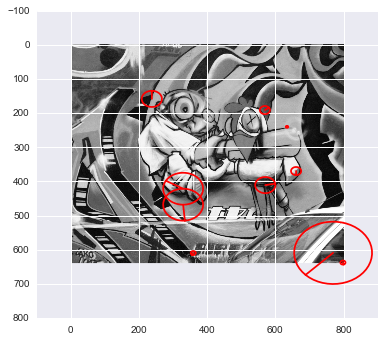

Variable containing:
 192.6634
[torch.FloatTensor of size 1]

Variable containing:
-0.1010 -0.1010  0.9615
 0.1010 -0.1010  0.9524
[torch.FloatTensor of size 2x3]



In [26]:
HA = HessianAffinePatchExtractor( mrSize = 3., num_features = 10, border = 16)
HA.train()
#nm = HA(var_image_reshape)
#sigma(i).^4
aff, patches, resp, pyr = HA(var_image_reshape)
LAFs = aff.data.cpu().numpy()
#print aff.shape
visualize_LAFs(var_image_reshape.data.cpu().numpy()[0,0,:,:], LAFs)

loss = torch.mean(resp * torch.sum(patches.view(patches.size(0),-1), dim =1))
loss += torch.clamp(patches.size(0)*1.0 - resp, min=0, max = patches.size(0)*1.0 ).mean()
print loss
print aff[0,:,:]
loss.backward()
#print affs
#print np.sum(aff.data.cpu().numpy())

#aff,patches,resp, pyr = HA(var_image_reshape)


In [133]:
def fold_aff_patches(patches, aff_m, h = 600, w = 800):
    out = torch.zeros(h,w)
    aff_m2 = aff_m
    aff_m2[:,:,2] = aff_m2[:,:,2] - 2.0
    H_m = torch.cat([aff_m2,
                     torch.cat([torch.zeros(aff_m.size(0),1, 2), torch.ones(aff_m.size(0),1,1)], dim = 2)], dim = 1)

    aff_m_inv = Variable(torch.zeros(aff_m.size(0), 2, 3))

    for i in range(patches.size(0)):
        aff_m_inv[i,:,:] = torch.inverse(H_m[i,:,:] )[:2,:]
    #aff_m_inv[:,:,2] = aff_m_inv[:,:,2] + 16.
    #aff_m_inv[:,:,:] = aff_m_inv[:,:,:] / 3.
    

    #aff_m_inv = aff_m_inv[0:20,:,:]
    print aff_m_inv[0:5,:,:]
    #sys.exit()
    grid = torch.nn.functional.affine_grid(aff_m_inv, torch.Size((aff_m_inv.size(0),
                                                               1,
                                                               h,w)))
    #print grid[0,:,:,:]
    out = torch.nn.functional.grid_sample(patches,  grid)
    return torch.max(out,dim = 0)[0]

Variable containing:
(0 ,.,.) = 
  12.6933

(1 ,.,.) = 
   0.0014

(2 ,.,.) = 
   0.0000

(3 ,.,.) = 
   0.0000

(4 ,.,.) = 
   0.0000

(5 ,.,.) = 
   0.0000

(6 ,.,.) = 
   0.0000

(7 ,.,.) = 
   0.0000

(8 ,.,.) = 
   0.0960

(9 ,.,.) = 
   0.3469

(10,.,.) = 
   0.0000

(11,.,.) = 
   0.0000

(12,.,.) = 
   0.0000

(13,.,.) = 
   0.0000

(14,.,.) = 
   0.0000

(15,.,.) = 
   0.0000

(16,.,.) = 
   0.0000

(17,.,.) = 
   0.0092

(18,.,.) = 
   0.8220

(19,.,.) = 
   0.7534

(20,.,.) = 
   0.5820

(21,.,.) = 
   0.1432

(22,.,.) = 
   0.1242

(23,.,.) = 
   0.1564

(24,.,.) = 
   0.1439

(25,.,.) = 
   0.1033

(26,.,.) = 
   0.1167

(27,.,.) = 
   0.1502

(28,.,.) = 
   0.0000

(29,.,.) = 
   0.0009

(30,.,.) = 
   0.0266

(31,.,.) = 
   0.0000

(32,.,.) = 
   0.0000

(33,.,.) = 
   0.0000

(34,.,.) = 
   0.0132

(35,.,.) = 
   0.0010

(36,.,.) = 
  14.7039

(37,.,.) = 
   0.5498

(38,.,.) = 
   0.6297

(39,.,.) = 
   0.3114

(40,.,.) = 
   0.2221

(41,.,.) = 
   0.1139

(42,.,.) = 
 

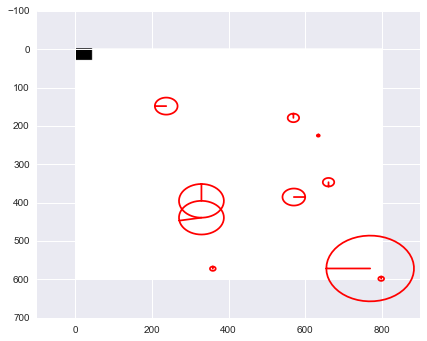

In [134]:

aff,patches,resp, pyr = HA(var_image_reshape)

folded_img = fold_aff_patches(patches,aff)

aff,patches,resp, pyr = HA(var_image_reshape)
LAFs = aff.data.cpu().numpy()
#print aff.shape
visualize_LAFs(255 - folded_img.data.cpu().numpy()[0,:,:], LAFs)
#folded_img = fold_aff_patches(patches,aff)
#plt.imshow(255 - folded_img.data.cpu().numpy()[0,:,:])
#plt.imshow(folded_img.cpu.numpy()[0,:,:])

In [194]:
#print folded_img.shape

In [112]:
plt.imshow(255 - patches.data.cpu().numpy()[452,0,:,:])

IndexError: index 452 is out of bounds for axis 0 with size 100

<type 'list'>


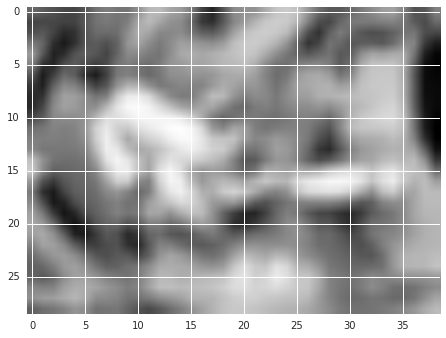

In [71]:
print type(pyr)
plt.imshow(255 -pyr[4].data.cpu().numpy()[0,0,:,:])

RuntimeError: there are no graph nodes that require computing gradients

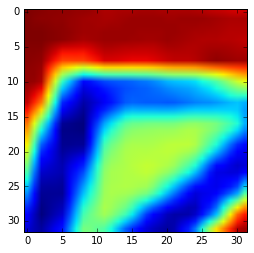

In [112]:
p1 = patches.data.cpu().numpy()[20,0,:,:]
plt.imshow(p1)



In [21]:
Hess = HessianResp()
resp = Hess(var_image_reshape)
#resp_np = resp.squeeze().data.cpu().numpy()
NMS = NMS2d(threshold = 0.01)
nms_map = NMS(resp)
print nms_map.shape
print nms_map

torch.Size([1, 1, 640, 800])
Variable containing:
( 0 , 0 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   1   0  ...    0   1   0
   0   0   0  ...    0   0   0
[torch.ByteTensor of size 1x1x640x800]



In [20]:
print np.sum(nms_map.data.cpu().numpy()[0,0,:,:])
#plt.imshow(nms_map.data.cpu().numpy()[0,0,:,:])

9977


In [ ]:
import torch
import torch.nn as nn
import numpy as np

def crop_center(img,cropx,cropy):, 
    y,x = img.shape
    if cropx < x:
        startx = x//2-(cropx//2)
        endx = startx+cropx
    else:
        startx = 0
        endx = x
    if cropy < y:
        starty = y//2-(cropy//2)
        endy = starty+cropy
    else:
        starty = 0
        endy = y
    return img[starty:endy,startx:endx]

class AffineFeatureDetector(nn.Module):
    def __init__(self, 
                 num_input_channels = 1,
                 num_ouput_channels = 64,
                 feature_net = None,
                 out_patch_size = 32,
                 out_stride = 8,
                 min_zoom = 1.0,
                 max_zoom = 1.0,
                 min_tilt = 1.0,
                 max_tilt = 1.0,
                 max_rot = 0,
                 max_shift = 0,
                 mrSize = 3.0, use_cuda = False):
        super(SpatialTransformer2d, self).__init__()
        
        ### geometrical restrictions
        self.in_planes = num_input_channels
        self.out_patch_size = out_patch_size;
        self.max_rot = max_rot;
        self.min_zoom = min_zoom;
        self.min_tilt = min_tilt;
        self.max_zoom = max_zoom;
        self.max_tilt = max_tilt;
        self.max_shift = max_shift;
        self.mrSize = mrSize;
        self.extraction_mrSize = self.max_zoom * (1.0 + self.max_shift) * self.mrSize;
        self.use_cuda = use_cuda;
        self.gridPatchSize = int(np.ceil( self.extraction_mrSize * self.out_patch_size))
        ###
        if feature_net is None:
            self.spatial_transformer_feature_net = nn.Sequential(
                nn.Conv2d(num_input_channels, 16, kernel_size=3, padding = 1, bias = False),
                nn.BatchNorm2d(16, affine=False),
                nn.ReLU(),
                nn.Conv2d(16, 16, kernel_size=3, padding=1, bias = False),
                nn.BatchNorm2d(16, affine=False),
                nn.ReLU(),
                nn.Conv2d(16, num_ouput_channels, kernel_size=3, padding=1, bias = False),
                nn.BatchNorm2d(num_ouput_channels, affine=False),
        else:
            self.spatial_transformer_feature_net = feature_net
        if self.use_cuda:
            self.spatial_transformer_feature_net.cuda()
        stride_h, stride_w = self.get_net_stride()
        assert stride_h == stride_w # I am too lazy to deal with non-square patches
        self.ST_features_stride = stride_h
        assert self.ST_features_stride <= out_stride  #
        assert out_stride % self.ST_features_stride == 0 #Otherwise we are in trouble
        self.last_layer_stride = int(out_stride / self.ST_features_stride);
        
        self.out_patch_size = out_patch_size; 
        self.out_stride = out_stride;# num of strides in ST net

        ### Parameters networks 
        self.psi_net =  nn.Sequential(
            nn.Conv2d(num_ouput_channels, 1, kernel_size=self.last_layer_stride, bias = True, stride = self.last_layer_stride),
            nn.Tanh()
        )
        self.theta_net = nn.Sequential(
            nn.Conv2d(num_ouput_channels, 1, kernel_size=self.last_layer_stride, bias = True, stride = self.last_layer_stride),
            nn.Tanh()
        )
        self.shift_net = nn.Sequential(
            nn.Conv2d(num_ouput_channels, 2, kernel_size=self.last_layer_stride, bias = True, stride = self.last_layer_stride),
            nn.Tanh()
        )
        self.iso_scale_net = nn.Sequential(
            nn.Conv2d(num_ouput_channels, 1, kernel_size=self.last_layer_stride, bias = True, stride = self.last_layer_stride),
            nn.Tanh()
        )
        self.horizontal_tilt_net = nn.Sequential(
            nn.Conv2d(num_ouput_channels, 1, kernel_size=self.last_layer_stride, bias = True, stride = self.last_layer_stride),
            nn.Tanh()
        )
        ### Useful constants
        self.eye2 = torch.autograd.Variable(torch.eye(2))
        self.zero = torch.autograd.Variable(torch.zeros(1,1,1))
        self.one = torch.autograd.Variable(torch.ones(1,1,1))
        if self.use_cuda:
            self.eye2 = self.eye2.cuda()
            self.zero = self.zero.cuda()
            self.one = self.one.cuda()
        return
    def get_net_stride(self):
        #Everything should be zero padded in ST_feature_net, so size is reduced be strides only 
        in_h = in_w = 1024
        inp = torch.autograd.Variable(torch.rand(1, self.in_planes, in_h, in_w))
        if self.use_cuda:
            inp = inp.cuda()
        out_f = self.spatial_transformer_feature_net.forward(inp)
        #print out_f.size();
        stride_h = in_h / out_f.size(2);
        stride_w = in_w / out_f.size(3);
        return stride_h, stride_w
    def get_rotation_matrix(self, angle_in_radians):
        angle_in_radians = angle_in_radians.view(-1, 1, 1);
        sin_a = torch.sin(angle_in_radians)
        cos_a = torch.cos(angle_in_radians)
        A1_x = torch.cat([cos_a, -sin_a], dim = 2)
        A2_x = torch.cat([sin_a, cos_a], dim = 2)
        transform = torch.cat([A1_x,A2_x], dim = 1)
        return transform

    def get_tilt_matrix(self, horizontal_tilt): #X-axis anisoptropic scale
        an_s = horizontal_tilt.view(-1, 1, 1)
        A1_x = torch.cat([an_s, self.zero.expand_as(an_s)], dim = 2)
        A2_x = torch.cat([self.zero.expand_as(an_s), self.one.expand_as(an_s) / an_s], dim = 2)
        return torch.cat([A1_x,A2_x], dim = 1)
    
    def get_scale_matrix(self, iso_scale): #Isotropic scale
        iso_s = iso_scale.view(-1, 1, 1)
        A1_x = torch.cat([iso_s, self.zero.expand_as(iso_s)], dim = 2)
        A2_x = torch.cat([self.zero.expand_as(iso_s), iso_s], dim = 2)
        return torch.cat([A1_x,A2_x], dim = 1)
    
    def compose_affine_matrix(self, psi, theta, iso_scale, horizontal_tilt, shift): 
        ## See illustration in MODS paper for notation
        # Output is n x 2 x 3 Affine transformation matrix 
        in_plane_rot =  self.get_rotation_matrix(psi);
        out_plane_rot = self.get_rotation_matrix(theta);
        tilt_matrix = self.get_tilt_matrix(horizontal_tilt);
        iso_scale = iso_scale.view(-1,1,1)
        A_iso_scale  = self.get_scale_matrix(iso_scale);
        A_iso_scale_in_plane = torch.bmm(A_iso_scale,in_plane_rot);
        A_tilt_out_of_place = torch.bmm(tilt_matrix, out_plane_rot)
        A_no_shift = torch.bmm(A_iso_scale_in_plane, A_tilt_out_of_place)
        return torch.cat([A_no_shift, shift.view(-1,2,1)], dim = 2)

    def unfold_patches_for_grid(self,input_image):
        #To avoid zeros, we should sample transformed patch from bigger patch, that final (in case of zoom-out or tilt)
        #needed_y = int(np.ceil(float(input_image.size(2)) / self.out_stride))
        #needed_x = int(np.ceil(float(input_image.size(3)) / self.out_stride))
        #floor((L_{in}  + 2 * padding - dilation * (kernel\_size - 1) - 1) / stride + 1)`
        needed_y_pad = (self.psi.size(2) - 1) * self.out_stride + self.gridPatchSize - input_image.size(2)
        needed_x_pad = (self.psi.size(3) - 1) * self.out_stride + self.gridPatchSize - input_image.size(3)
        padx_2 = int(np.ceil(needed_x_pad / 2))
        pady_2 = int(np.ceil(needed_y_pad / 2))
        half_ps = self.gridPatchSize / 2
        padded = nn.ZeroPad2d((padx_2,needed_x_pad - padx_2, pady_2,needed_y_pad - pady_2))(input_image)
        #print input_image.shape, padded.shape
        inp_unfolded1 = padded.unfold(2, self.gridPatchSize, self.out_stride).squeeze(1);
        #print inp_unfolded1.shape
        inp_unfolded2 = inp_unfolded1.unfold(2,self.gridPatchSize, self.out_stride).squeeze(1);
        #print inp_unfolded2.shape
        
        inp_unfolded = inp_unfolded2.contiguous().view(-1,1,self.gridPatchSize,self.gridPatchSize)
        patch_centers_x = torch.arange(half_ps , input_image.size(3) + padx_2 + 1,
                                       step=self.out_stride) - padx_2;
        patch_centers_y = torch.arange(half_ps , input_image.size(2) + pady_2 + 1,
                                       step=self.out_stride) -  pady_2;
        patch_centers = torch.stack([patch_centers_x.repeat(patch_centers_y.size(0)), 
                                         patch_centers_y.repeat(patch_centers_x.size(0),1).t().contiguous().view(-1)],1)
        patch_centers = torch.autograd.Variable(patch_centers)
        if self.use_cuda:
            patch_centers = patch_centers.cuda()
        return inp_unfolded, patch_centers
    def fold_image_back_numpy(self, patches, image_width, image_height):
        from  scipy.ndimage import zoom as imzoom
        num,ch,patch_h, patch_w = patches.shape
        num_patches_y = int(np.floor(float(image_height) / self.out_stride));
        num_patches_x = int(np.floor(float(image_width) / self.out_stride));
        out_img = np.zeros((num_patches_y * self.out_stride ,num_patches_x * self.out_stride));
        #print out_img.shape
        #
        ps_in_img = self.out_stride;
        idx = 0
        make_bigger = False
        make_crop = False
        if ps_in_img > patch_w:
            make_bigger = True
            zoom = float(ps_in_img) / patch_w;
        elif ps_in_img < patch_w:
            make_crop = True
        for j in range(num_patches_y):
            for i in range(num_patches_x):
                if make_crop:
                    out_img[ps_in_img*j:ps_in_img*(j+1),ps_in_img*i:ps_in_img*(i+1)] =  crop_center(patches[idx ,0,:,:], ps_in_img,ps_in_img)
                elif make_bigger:
                    out_img[ps_in_img*j:ps_in_img*(j+1),ps_in_img*i:ps_in_img*(i+1)] =  imzoom(patches[idx ,0,:,:],(zoom,zoom))
                else:
                    out_img[ps_in_img*j:ps_in_img*(j+1),ps_in_img*i:ps_in_img*(i+1)] =  patches[idx ,0,:,:]
                idx+=1
        return crop_center(out_img, image_width, image_height)
    def input_norm(self,x):
        #Local patch normalization for descriptors.
        flat = x.view(x.size(0), -1)
        mp = torch.mean(flat, dim=1)
        sp = torch.std(flat, dim=1) + 1e-7
        return (x - mp.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand_as(x)) / sp.unsqueeze(-1).unsqueeze(-1).unsqueeze(1).expand_as(x)

    def forward(self, input_img):
        self.eye2 = torch.autograd.Variable(torch.eye(2))
        self.zero = torch.autograd.Variable(torch.zeros(1,1,1))
        self.one = torch.autograd.Variable(torch.ones(1,1,1))
        if self.use_cuda:
            self.eye2 = self.eye2.cuda()
            self.zero = self.zero.cuda()
            self.one = self.one.cuda()
        ST_features = self.spatial_transformer_feature_net(input_img)
        self.psi = self.max_rot * self.psi_net(ST_features)
        theta = self.max_rot * self.theta_net(ST_features)
        shift = self.max_shift * self.shift_net(ST_features) 
        tilt = torch.clamp(1.0 + (self.max_tilt - 1) * self.horizontal_tilt_net(ST_features),
                          min = self.min_tilt, max = self.max_tilt)
        scale = torch.clamp(1.0 + (self.max_zoom - 1) * self.iso_scale_net(ST_features),
                            min = self.min_zoom, max = self.max_zoom)

        transform = self.compose_affine_matrix(self.psi, theta, scale, tilt, shift)
        #print transform.shape
        #print transform
        grid = torch.nn.functional.affine_grid(transform, torch.Size((transform.size(0),
                                                           self.in_planes,
                                                           self.out_patch_size, 
                                                           self.out_patch_size)))
        #print grid.shape
        inp_unfolded, patch_centers = self.unfold_patches_for_grid(input_img);
        
        grid =  grid / float(self.gridPatchSize / self.out_patch_size)
        #adjust grid for taking bigger input patch
        #to avoid empty places. Input patch size is calculates in unfold_patches_for_grid function
        #print inp_unfolded.shape,grid.shape
        transformed_patches = torch.nn.functional.grid_sample(inp_unfolded, grid)
        affine_matrices_out = self.out_patch_size * transform
        #print patch_centers.shape,affine_matrices_out[:,:,2].shape
        affine_matrices_out[:,:,2] =  patch_centers + affine_matrices_out[:,:,2];
        return transformed_patches, affine_matrices_out


In [ ]:
def 